<a href="https://colab.research.google.com/github/tiaracantiq/gitgithub/blob/main/Image_Segmentation_dengan_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install tensorflow tensorflow-datasets matplotlib

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-gmaemmkw
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-gmaemmkw
  Resolved https://github.com/tensorflow/examples.git to commit 5c3457ae6f82453580df0800511033472c3dc584
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746028588.526394427792345445866534157219010350645891679620-py3-none-any.whl size=301651 sha256=7b8170faefab6a001ba19e3ca40373db9f07fe08d1b5a44d5e1aa1a00d2fd043
  Stored in directory: /tmp/pip-ephem-wheel-cache-3jae2u3b/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [4]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.E31TF5_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.E31TF5_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


In [6]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [8]:
@tf.function
def load_image_train(datapoint):
    # Resize image and mask to 128x128
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Random horizontal flip (50% probability)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # Normalize image and mask
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
def load_image_test(datapoint):
    # Resize the input image and segmentation mask to 128x128 pixels
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    # Normalize the image and mask
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [10]:
# Define dataset parameters
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [11]:
# Apply preprocessing to train and test datasets
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [12]:
# Create final dataset pipelines
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [13]:
def display(display_list):
    """Display images and masks in a row with titles"""
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

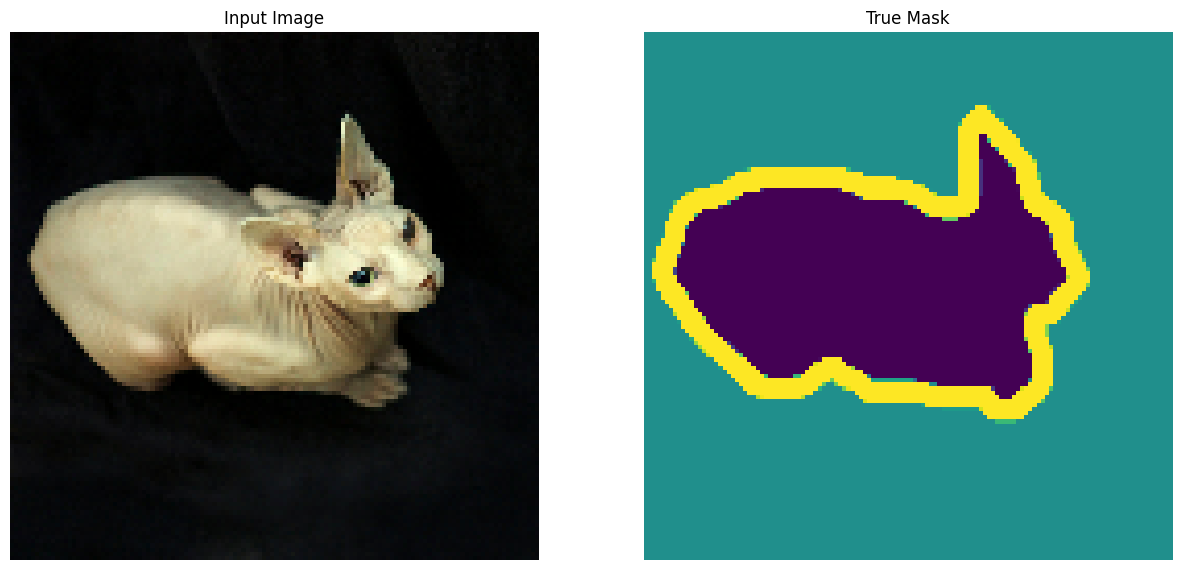

In [14]:
# Visualize a sample from the training set
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

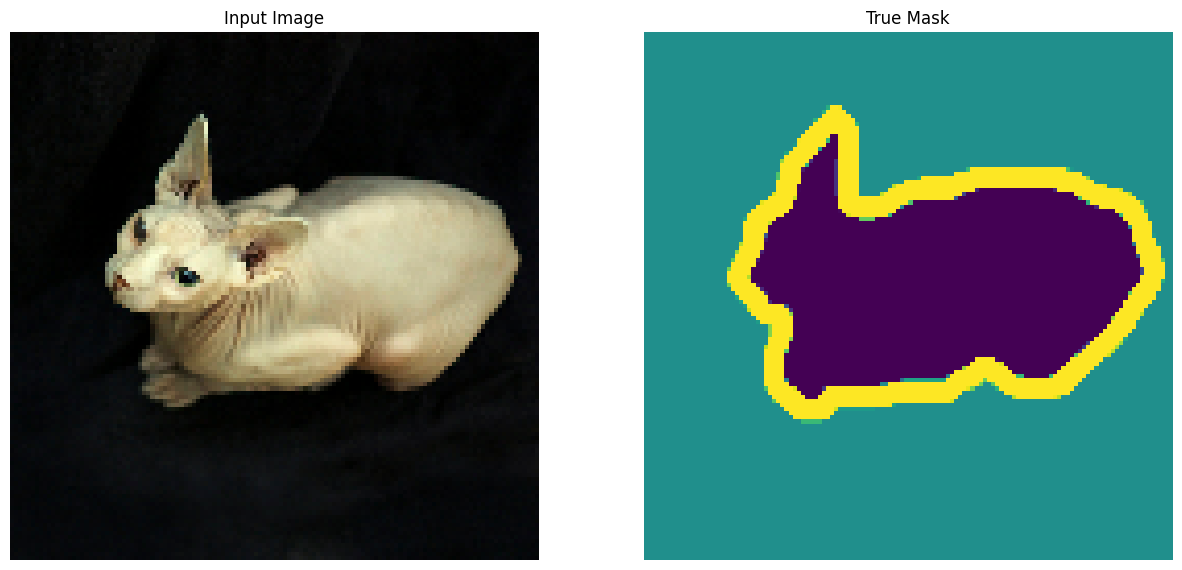

In [16]:
def display(display_list):
    """Display images and masks in a row with titles"""
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

# Visualize a sample from the training set
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [46]:
OUTPUT_CHANNELS = 3

In [49]:
# Load MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3],
    include_top=False,
    weights='imagenet'
)

# Specify the layers to use for skip connections
layer_names = [
    'block_1_expand_relu',    # 64x64 features
    'block_3_expand_relu',    # 32x32 features
    'block_6_expand_relu',    # 16x16 features
    'block_13_expand_relu',   # 8x8 features
    'block_16_project'        # 4x4 features
]
# Get outputs from specified layers
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(
    inputs=base_model.input,  # Corrected from inputs- to inputs=
    outputs=base_model_outputs  # Corrected from outputs- to outputs=
)

# Freeze the base model weights
down_stack.trainable = False  # Corrected from false to False (Python is case-sensitive)

In [40]:
# Define the upsampling path
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    # Input layer
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the base model
    skips = down_stack(inputs)
    x = skips[-1]  # Get the deepest layer output
    skips = reversed(skips[:-1])  # Reverse and exclude the deepest layer

    # Upsampling with skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)  # Apply upsampling
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])  # Add skip connection

    # Final upsampling layer
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  # 64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [50]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

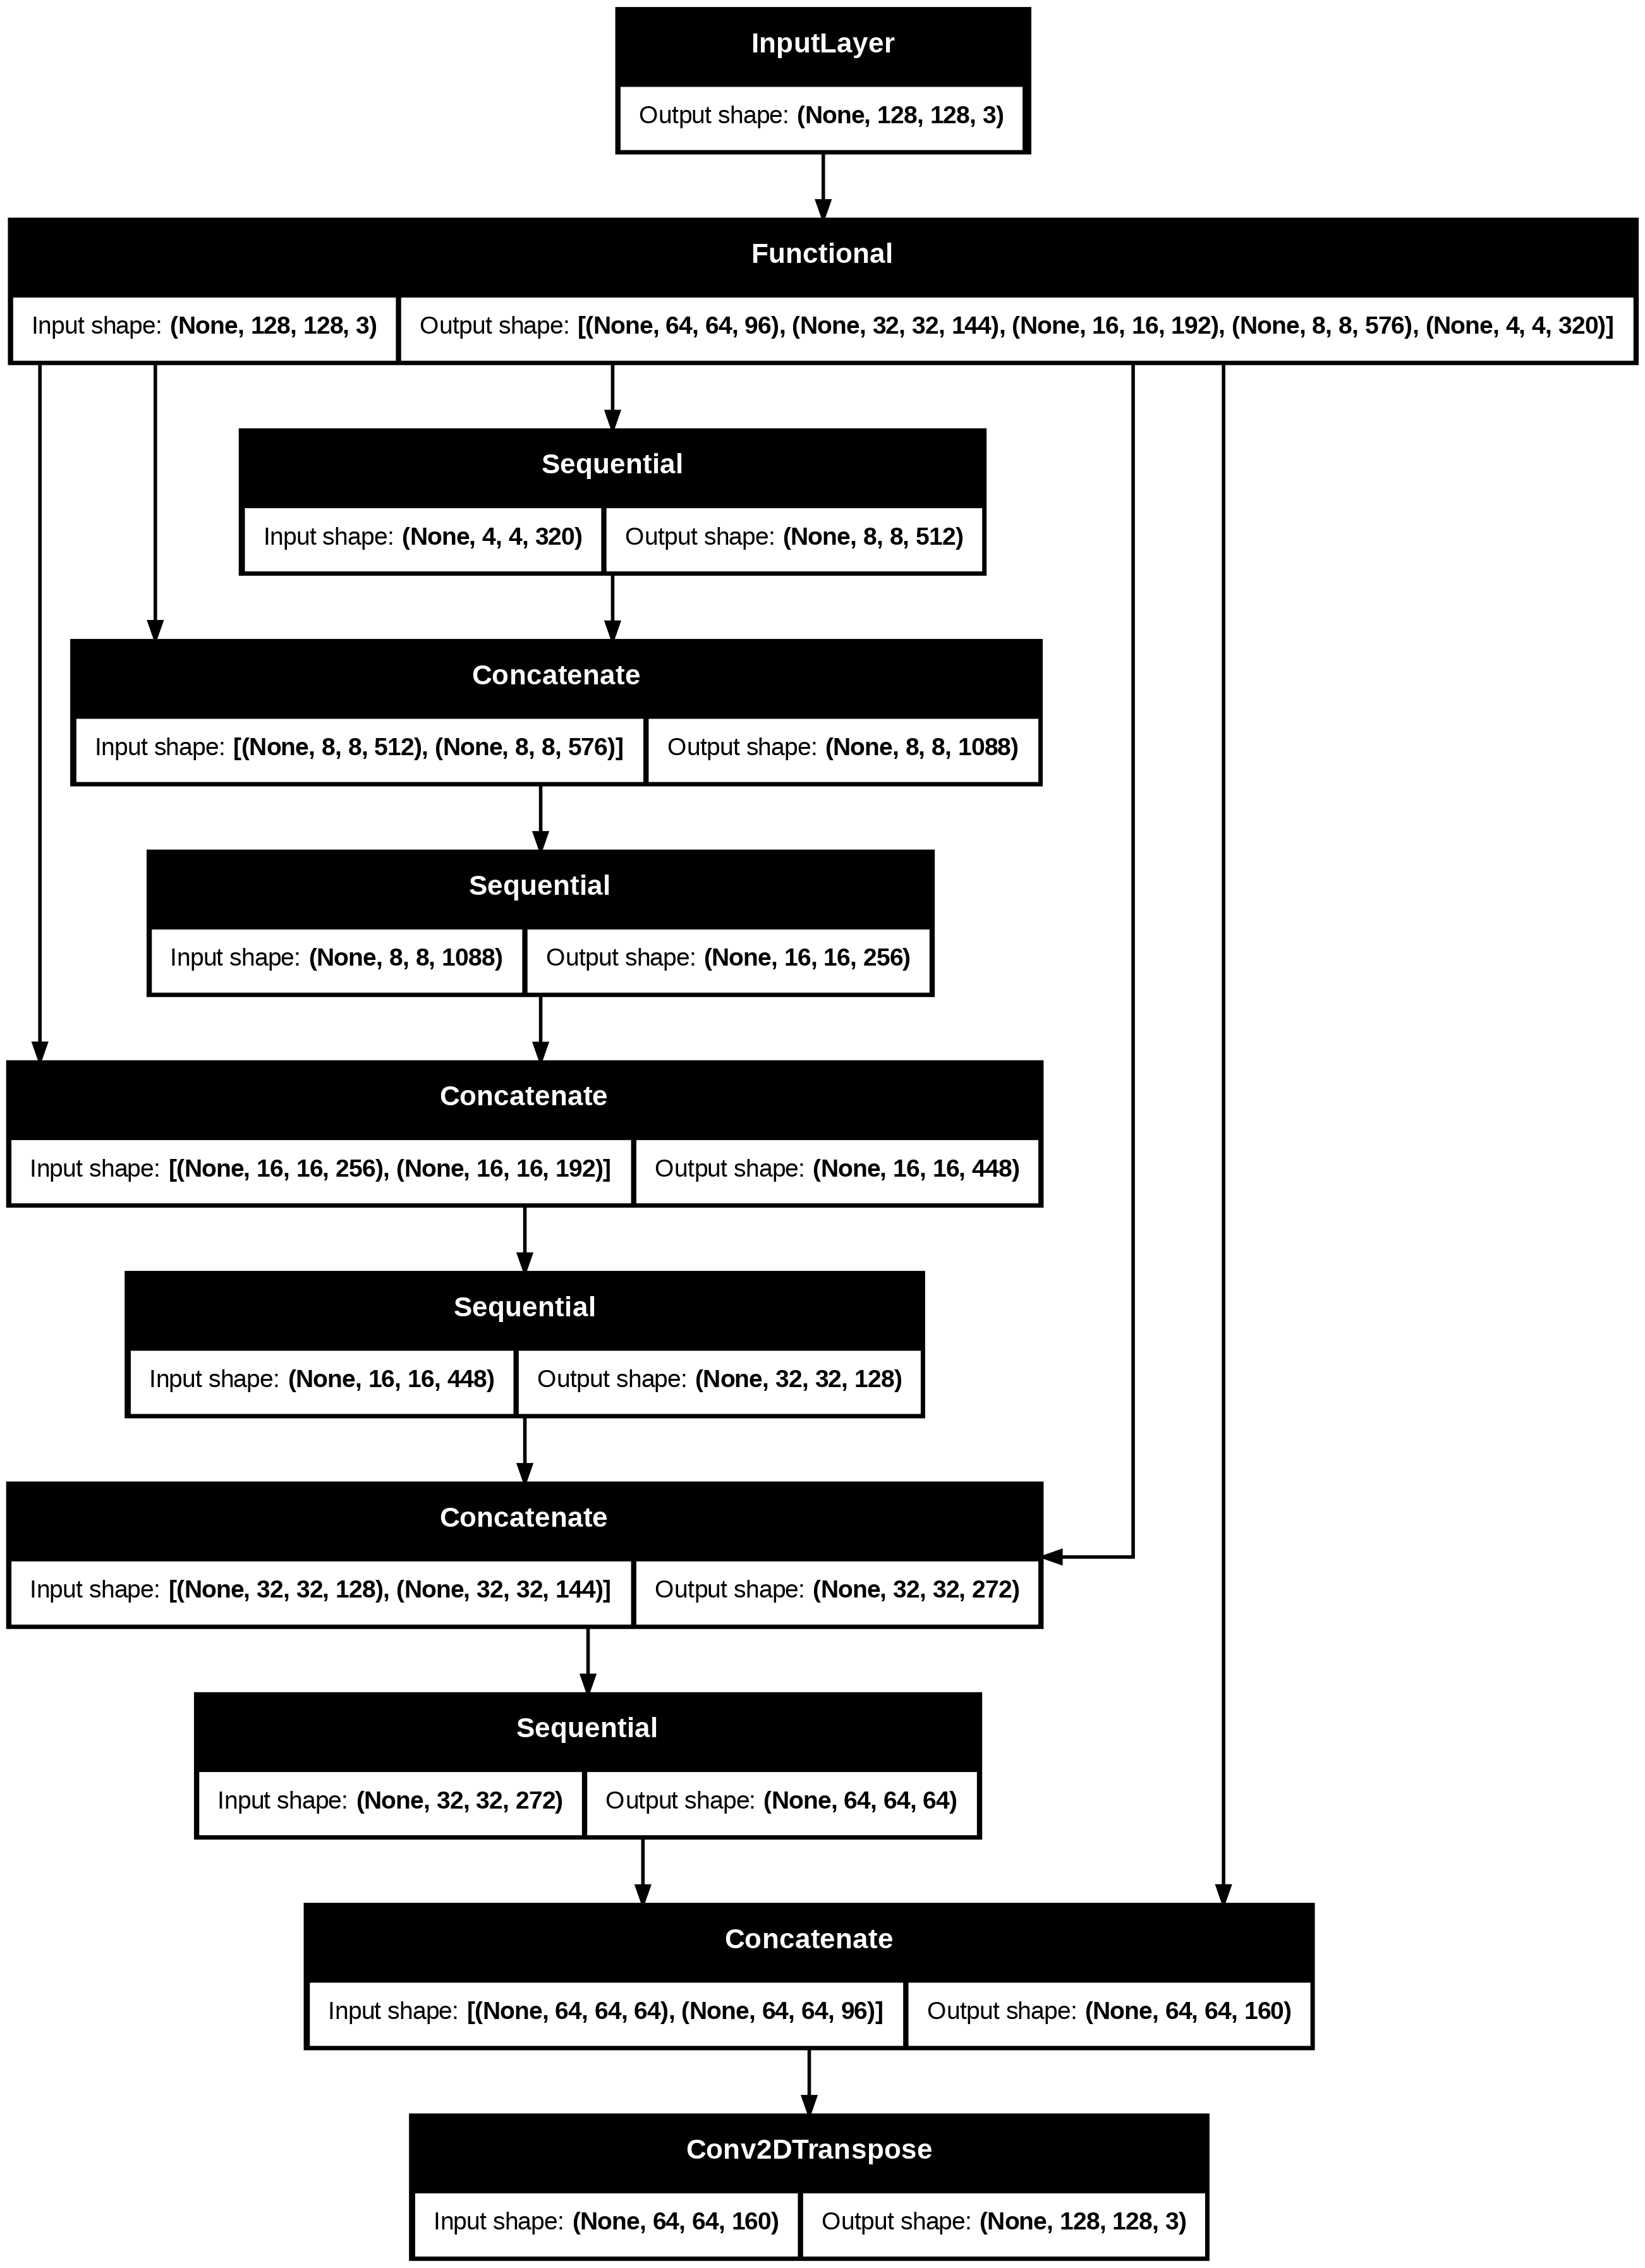

In [51]:
tf.keras.utils.plot_model(model,show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


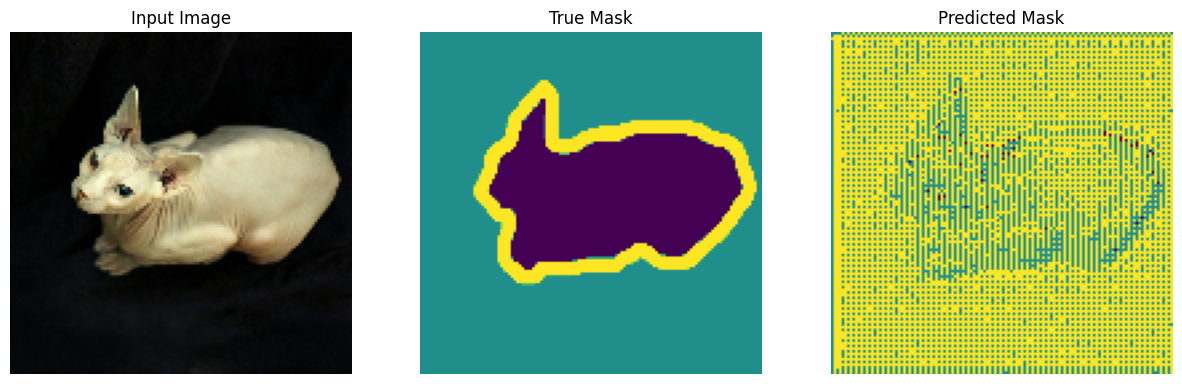

In [52]:
def create_mask(pred_mask):
    """Convert prediction output to a displayable mask"""
    pred_mask = tf.argmax(pred_mask, axis=-1)  # Get class with highest probability
    pred_mask = pred_mask[..., tf.newaxis]  # Add channel dimension
    return pred_mask[0]  # Return first mask in batch

def show_predictions(dataset=None, num=1):
    """Display model predictions with comparison to ground truth"""
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        # Display sample prediction
        display([sample_image, sample_mask,
               create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Display predictions
show_predictions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


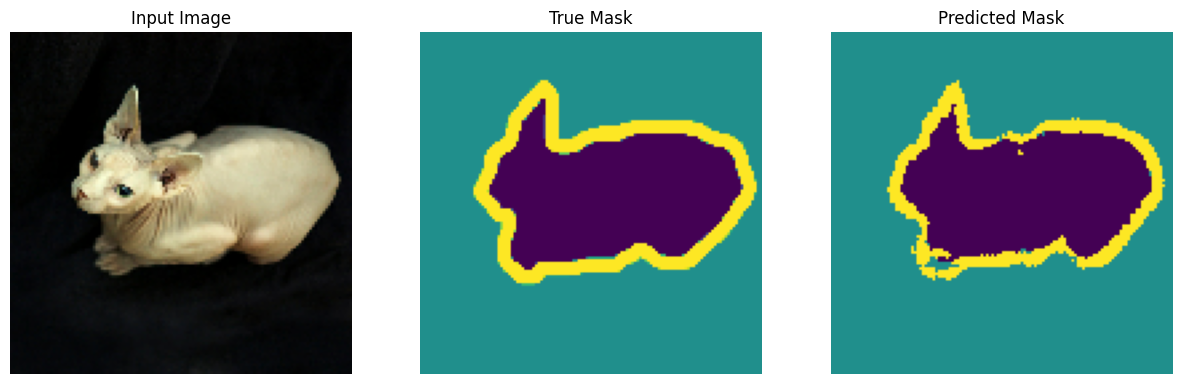


Sample Prediction after epoch 5

57/57 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.8939 - loss: 0.2538 - val_accuracy: 0.8832 - val_loss: 0.2849


In [53]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Display predictions at the end of each epoch"""
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

# Training parameters
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

# Train the model
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()]
)

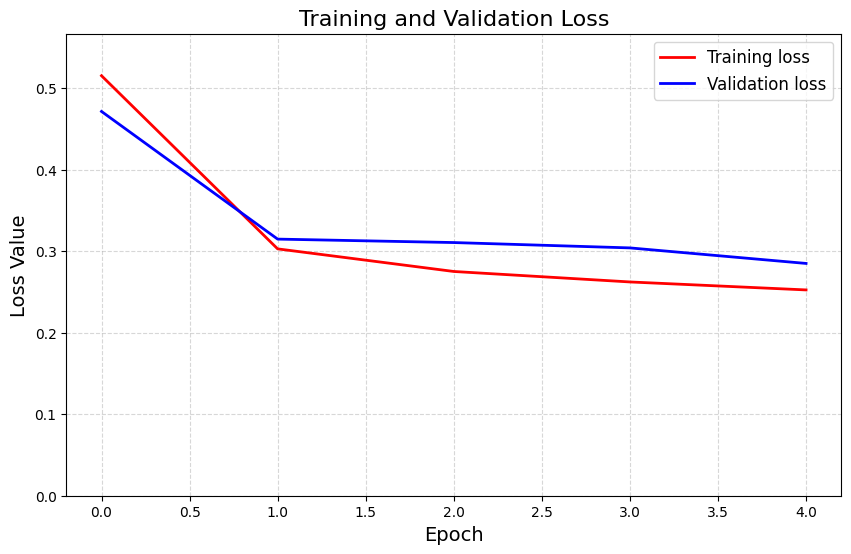

In [54]:
# Get the loss values from history
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Create range of epochs
epochs = range(EPOCHS)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'r', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'b', linewidth=2, label='Validation loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss Value', fontsize=14)
plt.ylim([0, max(max(loss), max(val_loss)) * 1.1])  # Dynamic y-axis limit
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


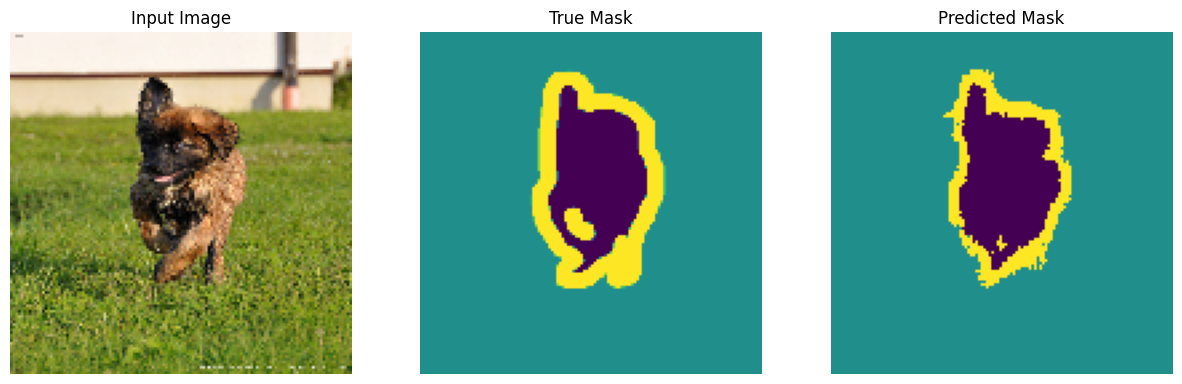

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


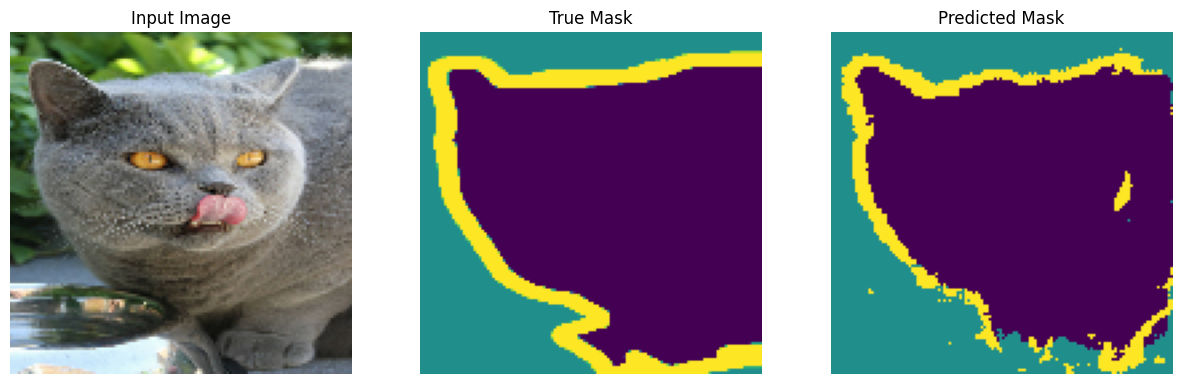

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


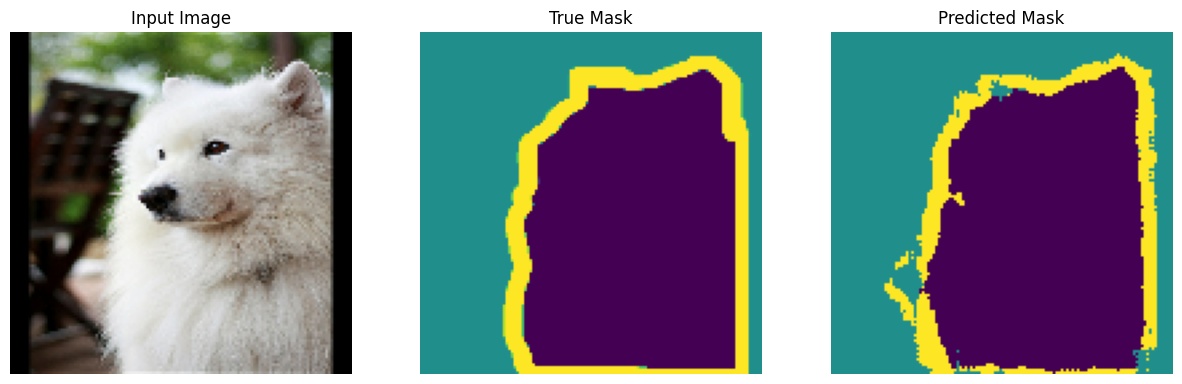

In [55]:
show_predictions (test_dataset, 3)

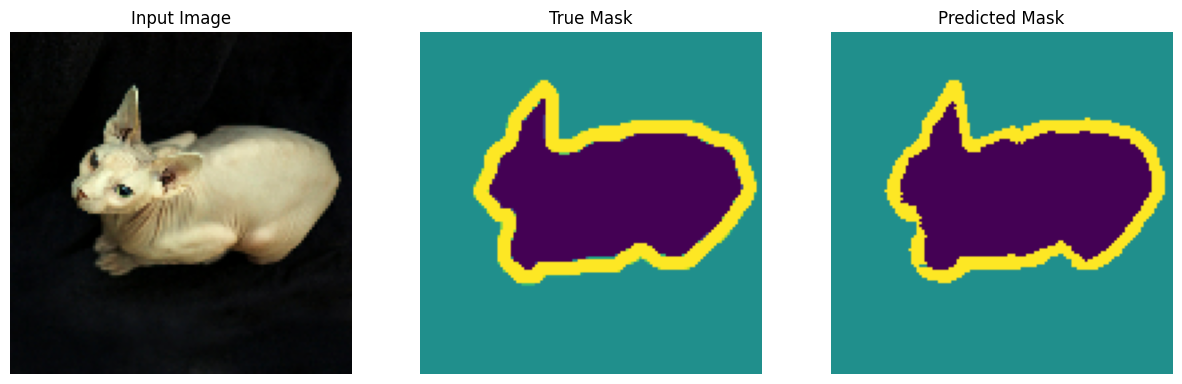


Sample Prediction after epoch 14

57/57 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - accuracy: 0.9352 - loss: 0.1430 - val_accuracy: 0.8907 - val_loss: 0.3224
Epoch 15/15
42/57 ━━━━━━━━━━━━━━━━━━━━ 1:28 6s/step - accuracy: 0.9370 - loss: 0.1383

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        """Display predictions at the end of each epoch"""
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch + 1))

# Training parameters
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

# Train the model
model_history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[DisplayCallback()]
)